In [1]:
# Bandits

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import gym
import gym_bandits
import numpy as np
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

# Baseline strategies

In [4]:
def pure_exploitation(env, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'Pure exploitation'
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        action = np.argmax(Q)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [5]:
def pure_exploration(env, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'Pure exploration'
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        action = np.random.randint(env.action_space.n)
        
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

# Simple strategies

In [6]:
def epsilon_greedy(env, epsilon=0.01, n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'E-greedy {}'.format(epsilon)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        if np.random.random() > epsilon:
            action = np.argmax(Q)
        else:
            action = env.action_space.sample()

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [7]:
def lin_dec_epsilon_greedy(env,
                           init_epsilon=1.0,
                           min_epsilon=0.01, 
                           decay_ratio=0.05, 
                           n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'Lin e-greedy {} {} {}'.format(init_epsilon, 
                                          min_epsilon, 
                                          decay_ratio)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        decay_episodes = n_episodes * decay_ratio
        epsilon = 1 - e / decay_episodes
        epsilon = (init_epsilon - min_epsilon) * epsilon + min_epsilon
        epsilon = np.clip(epsilon, min_epsilon, init_epsilon)
        if np.random.random() > epsilon:
            action = np.argmax(Q)
        else:
            action = env.action_space.sample()

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [8]:
def exp_dec_epsilon_greedy(env, 
                           init_epsilon=1.0,
                           min_epsilon=0.01,
                           decay_ratio=0.1,
                           n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)

    decay_episodes = int(n_episodes * decay_ratio)
    rem_episodes = n_episodes - decay_episodes
    epsilons = 0.01
    epsilons /= np.logspace(-2, 0, decay_episodes)
    epsilons *= init_epsilon-min_epsilon
    epsilons += min_epsilon
    epsilons = np.pad(epsilons, (0, rem_episodes), 'edge')

    name = 'Exp e-greedy {} {} {}'.format(init_epsilon, 
                                          min_epsilon, 
                                          decay_ratio)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        if np.random.random() > epsilons[e]:
            action = np.argmax(Q)
        else:
            action = env.action_space.sample()

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [9]:
def optimistic_initialization(env, 
                              optimistic_estimate=1.0,
                              initial_count=100,
                              n_episodes=5000):
    Q = np.full((env.action_space.n), optimistic_estimate, dtype=np.float64)
    N = np.full((env.action_space.n), initial_count, dtype=np.float64)
    
    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'Optimistic {} {}'.format(optimistic_estimate, 
                                     initial_count)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        action = np.argmax(Q)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

# 2-armed bandit environments

In [10]:
b2_Vs = []
for seed in [12, 34, 56, 78, 90]:
    env_name = 'BanditTwoArmedUniform-v0'
    np.random.seed(seed) ; random.seed(seed)
    env = gym.make(env_name) ; env.seed(seed) ; env.reset()
    b2_Q = np.array(env.env.p_dist * env.env.r_dist)
    print('2-armed bandit with seed', seed)
    print('Probability of reward:', env.env.p_dist)
    print('Reward:', env.env.r_dist)
    print('Q(.):', b2_Q)
    b2_Vs.append(np.max(b2_Q))
    print('V*:', b2_Vs[-1])
    print()
print('Mean V* across all seeds:', np.mean(b2_Vs))

2-armed bandit with seed 12
Probability of reward: [0.15416284 0.7400497 ]
Reward: [1 1]
Q(.): [0.15416284 0.7400497 ]
V*: 0.7400496965154048

2-armed bandit with seed 34
Probability of reward: [0.03856168 0.78010046]
Reward: [1 1]
Q(.): [0.03856168 0.78010046]
V*: 0.780100460524675

2-armed bandit with seed 56
Probability of reward: [0.98419185 0.33341227]
Reward: [1 1]
Q(.): [0.98419185 0.33341227]
V*: 0.9841918505425767

2-armed bandit with seed 78
Probability of reward: [0.04818123 0.68096301]
Reward: [1 1]
Q(.): [0.04818123 0.68096301]
V*: 0.6809630138677178

2-armed bandit with seed 90
Probability of reward: [0.1530542  0.15768566]
Reward: [1 1]
Q(.): [0.1530542  0.15768566]
V*: 0.15768566100940729

Mean V* across all seeds: 0.6685981364919563


# Running simple strategies on 2-armed bandit environments

In [11]:
def b2_run_simple_strategies_experiment(env_name='BanditTwoArmedUniform-v0'):
    results = {}
    for seed in tqdm([12, 34, 56, 78, 90], desc='All experiments'):
        experiments = [
            # baseline strategies
            lambda env: pure_exploitation(env),
            lambda env: pure_exploration(env),

            # epsilon greedy
            lambda env: epsilon_greedy(env, epsilon=0.006),
            lambda env: epsilon_greedy(env, epsilon=0.01),

            # epsilon greedy linearly decaying
            lambda env: lin_dec_epsilon_greedy(env, 
                                               init_epsilon=1.0, 
                                               min_epsilon=0.0, 
                                               decay_ratio=0.002),
            lambda env: lin_dec_epsilon_greedy(env, 
                                               init_epsilon=0.4, 
                                               min_epsilon=0.0001, 
                                               decay_ratio=0.006),

            # epsilon greedy exponentially decaying
            lambda env: exp_dec_epsilon_greedy(env, 
                                               init_epsilon=1.0, 
                                               min_epsilon=0.0001,
                                               decay_ratio=0.001),
            lambda env: exp_dec_epsilon_greedy(env, 
                                               init_epsilon=0.5, 
                                               min_epsilon=0.0, 
                                               decay_ratio=0.003),

            # optimistic
            lambda env: optimistic_initialization(env, 
                                                  optimistic_estimate=0.5, 
                                                  initial_count=1000),
            lambda env: optimistic_initialization(env, 
                                                  optimistic_estimate=1.0, 
                                                  initial_count=50),
        ]
        for experiment in tqdm(experiments, 
                               desc='Experiments with seed {}'.format(seed), 
                               leave=False):
            np.random.seed(seed) ; random.seed(seed)
            env = gym.make(env_name) ; env.seed(seed) ; env.reset()   
            name, Re, Qe, Ae = experiment(env)
            Ae = np.expand_dims(Ae, -1)
            true_Q = np.array(env.env.p_dist * env.env.r_dist)
            opt_V = np.max(true_Q)
            episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
            Q_selected = np.take_along_axis(
                np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
            regret = opt_V - Q_selected
            cum_regret = np.cumsum(regret)
            if name not in results.keys(): results[name] = {}
            if 'Re' not in results[name].keys(): results[name]['Re'] = []
            if 'Qe' not in results[name].keys(): results[name]['Qe'] = []
            if 'Ae' not in results[name].keys(): results[name]['Ae'] = []
            if 'cum_regret' not in results[name].keys(): 
                results[name]['cum_regret'] = []
            if 'episode_mean_rew' not in results[name].keys(): 
                results[name]['episode_mean_rew'] = []
            
            results[name]['Re'].append(Re)
            results[name]['Qe'].append(Qe)
            results[name]['Ae'].append(Ae)
            results[name]['cum_regret'].append(cum_regret)
            results[name]['episode_mean_rew'].append(episode_mean_rew)
    return results

b2_results_s = b2_run_simple_strategies_experiment()

# Plotting results of simple strategies on 2-armed bandit environments

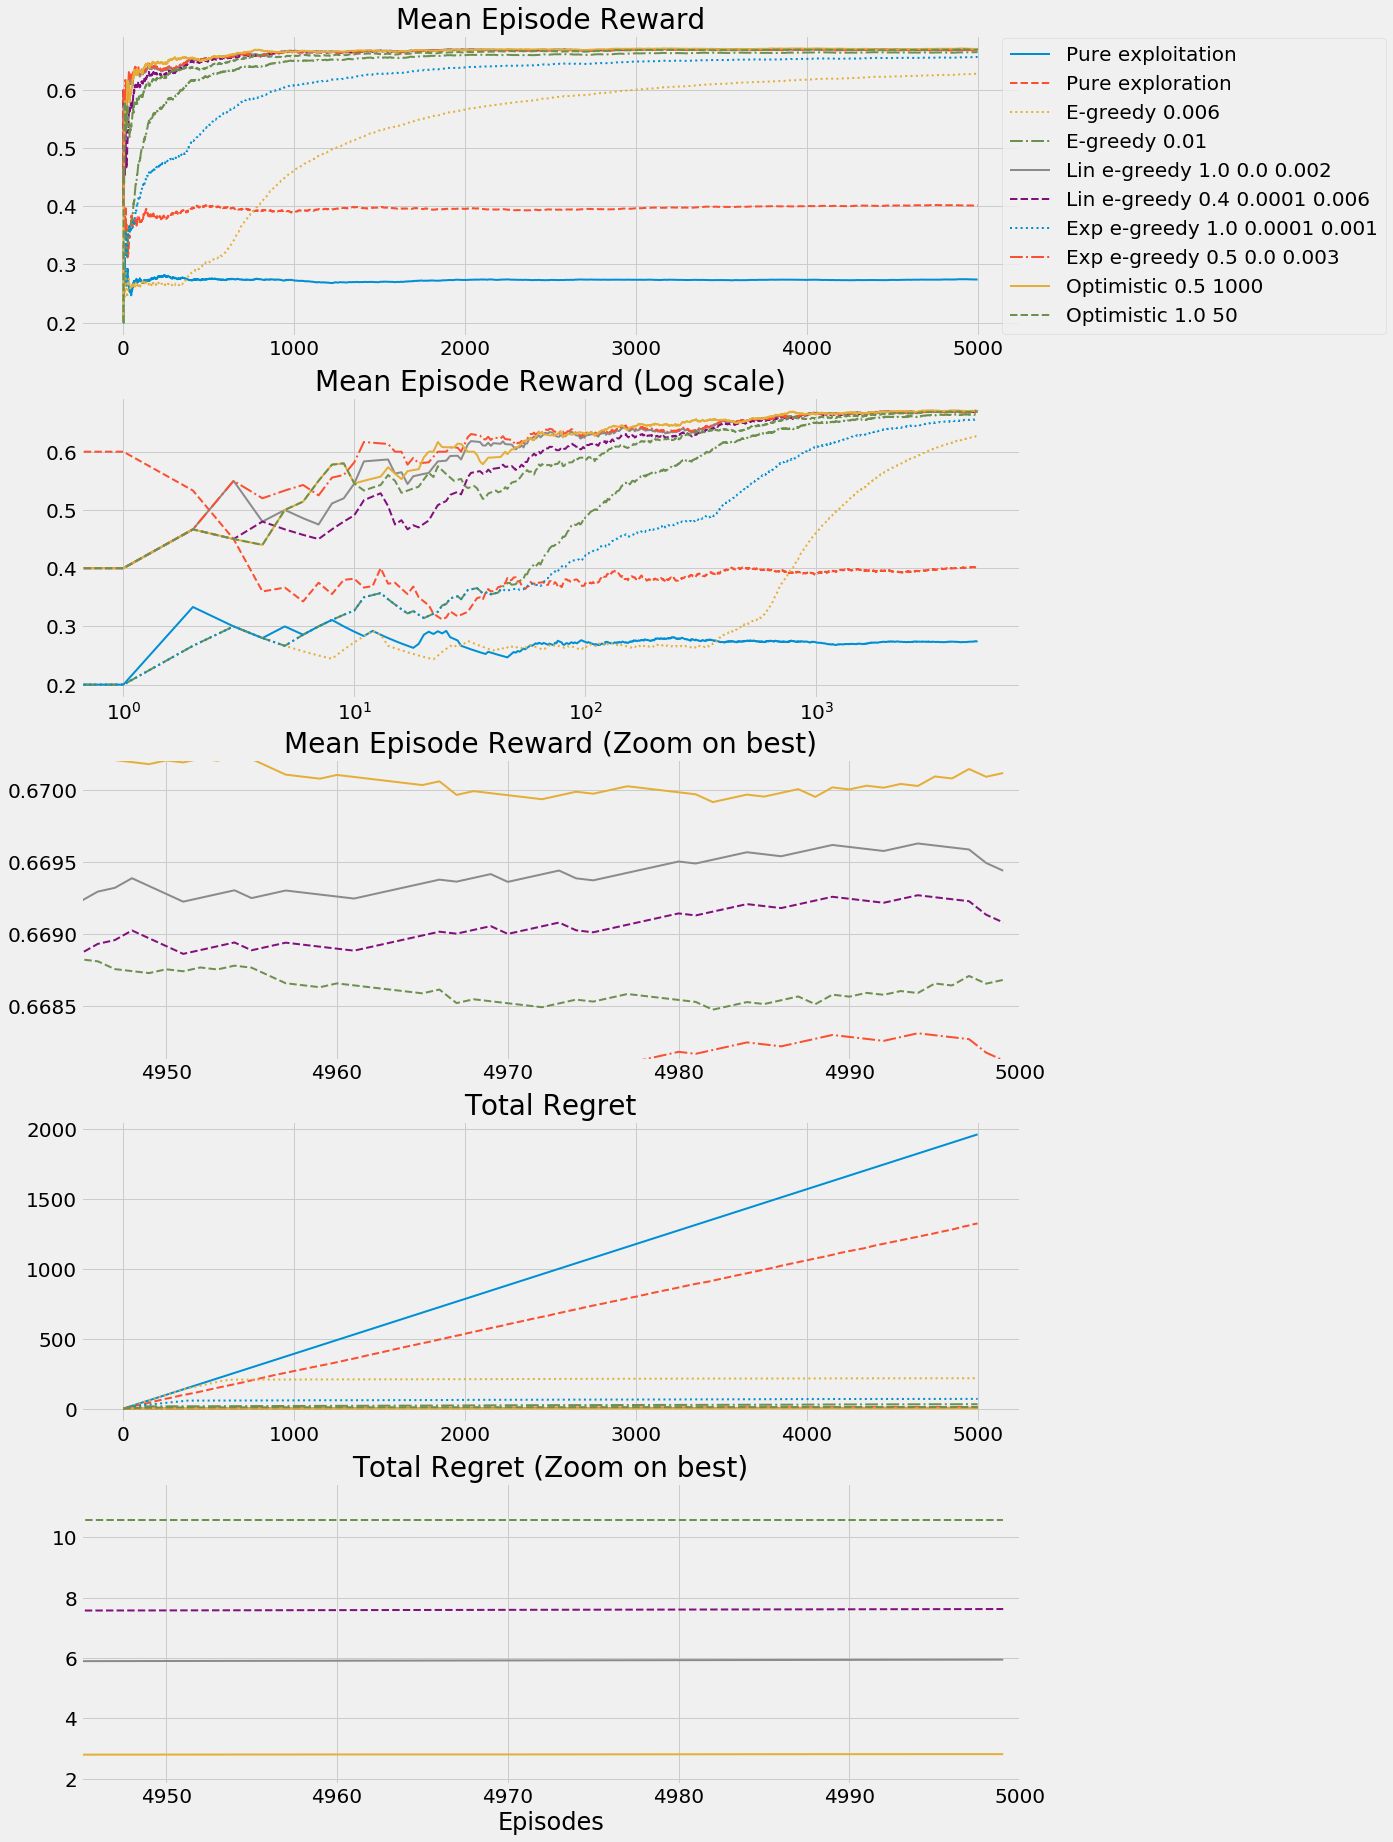

In [12]:
fig, axs = plt.subplots(5, 1, figsize=(15, 30), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b2_results_s.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((mean_episode_mean_rew.shape[0]*0.989,
                 mean_episode_mean_rew.shape[0],
                 max_ret-0.002,
                 max_ret+0.0001))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((mean_cum_regret.shape[0]*0.989,
              mean_cum_regret.shape[0],
              min_reg-1,
              min_reg+9))

    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.5))

plt.show()

# Advanced strategies

In [13]:
def softmax(env, 
            init_temp=1.0, 
            min_temp=0.3,
            decay_ratio=0.04,
            n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'SoftMax {} {} {}'.format(init_temp, 
                                     min_temp, 
                                     decay_ratio)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        decay_episodes = n_episodes * decay_ratio
        temp = 1 - e / decay_episodes
        temp = (init_temp - min_temp) * temp + min_temp
        temp = np.clip(temp, min_temp, init_temp)

        scaled_Q = Q/temp
        norm_Q = scaled_Q - scaled_Q.max()
        exp = np.exp(norm_Q)
        probs = exp / np.sum(exp)
        assert np.isclose(probs.sum(), 1.0)
        action = np.random.choice(np.arange(len(probs)), 
                                  size=1, 
                                  p=probs)[0]

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [14]:
def upper_confidence_bound(env, 
                           c=2, 
                           n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'UCB {}'.format(c)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        action = e
        if e >= len(Q):
            U = np.sqrt(c * np.log(e)/N)
            action = np.argmax(Q + U)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [15]:
def thompson_sampling(env, 
             tau=1,
             n_episodes=5000):
    Q = np.zeros((env.action_space.n))
    QN = np.zeros((env.action_space.n))
    R = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))
    means = np.zeros((env.action_space.n))
    
    Qe = np.empty((n_episodes, env.action_space.n))
    returns = np.empty(n_episodes)
    actions = np.empty(n_episodes, dtype=np.int)
    name = 'Thompson Sampling {}'.format(tau)
    for e in tqdm(range(n_episodes), 
                  desc='Episodes for: ' + name, 
                  leave=False):
        action = e
        if e >= len(N):
            samples = np.random.randn() / np.sqrt(N) + means
            action = np.argmax(samples)

        _, reward, _, _ = env.step(action)
        R[action] += reward
        N[action] += tau
        means[action] = tau * R[action] / N[action]
        
        QN[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/QN[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

# Running advanced strategies on 2-armed bandit environments

In [16]:
def b2_run_advanced_strategies_experiment(env_name='BanditTwoArmedUniform-v0'):
    results = {}
    for seed in tqdm([12, 34, 56, 78, 90], desc='All experiments'):
        experiments = [
            # baseline strategies 
            lambda env: pure_exploitation(env),
            lambda env: pure_exploration(env),

            # best from simple strategies
            lambda env: lin_dec_epsilon_greedy(env, 
                                               init_epsilon=0.4, 
                                               min_epsilon=0.0001, 
                                               decay_ratio=0.006),
            lambda env: optimistic_initialization(env, 
                                                  optimistic_estimate=1.0, 
                                                  initial_count=50),
            
            # softmax
            lambda env: softmax(env, init_temp=1.0, 
                                min_temp=0.1, 
                                decay_ratio=0.001),
            lambda env: softmax(env, 
                                init_temp=0.5, 
                                min_temp=0.05, 
                                decay_ratio=0.0001),

            # ucb
            lambda env: upper_confidence_bound(env, c=0.1),
            lambda env: upper_confidence_bound(env, c=2.0),

            # thompson sampling
            lambda env: thompson_sampling(env, tau=10),
            lambda env: thompson_sampling(env, tau=100),
        ]
        for experiment in tqdm(experiments, 
                               desc='Experiments with seed {}'.format(seed), 
                               leave=False):
            np.random.seed(seed) ; random.seed(seed)
            env = gym.make(env_name) ; env.seed(seed) ; env.reset()    
            name, Re, Qe, Ae = experiment(env)
            Ae = np.expand_dims(Ae, -1)
            true_Q = np.array(env.env.p_dist * env.env.r_dist)
            opt_V = np.max(true_Q)
            episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
            Q_selected = np.take_along_axis(
                np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
            regret = opt_V - Q_selected
            cum_regret = np.cumsum(regret)
            if name not in results.keys(): results[name] = {}
            if 'Re' not in results[name].keys(): results[name]['Re'] = []
            if 'Qe' not in results[name].keys(): results[name]['Qe'] = []
            if 'Ae' not in results[name].keys(): results[name]['Ae'] = []
            if 'cum_regret' not in results[name].keys(): 
                results[name]['cum_regret'] = []
            if 'episode_mean_rew' not in results[name].keys(): 
                results[name]['episode_mean_rew'] = []
            
            results[name]['Re'].append(Re)
            results[name]['Qe'].append(Qe)
            results[name]['Ae'].append(Ae)
            results[name]['cum_regret'].append(cum_regret)
            results[name]['episode_mean_rew'].append(episode_mean_rew)
    return results

b2_results_a = b2_run_advanced_strategies_experiment()

# Plotting results of advanced strategies on 2-armed bandit  environments

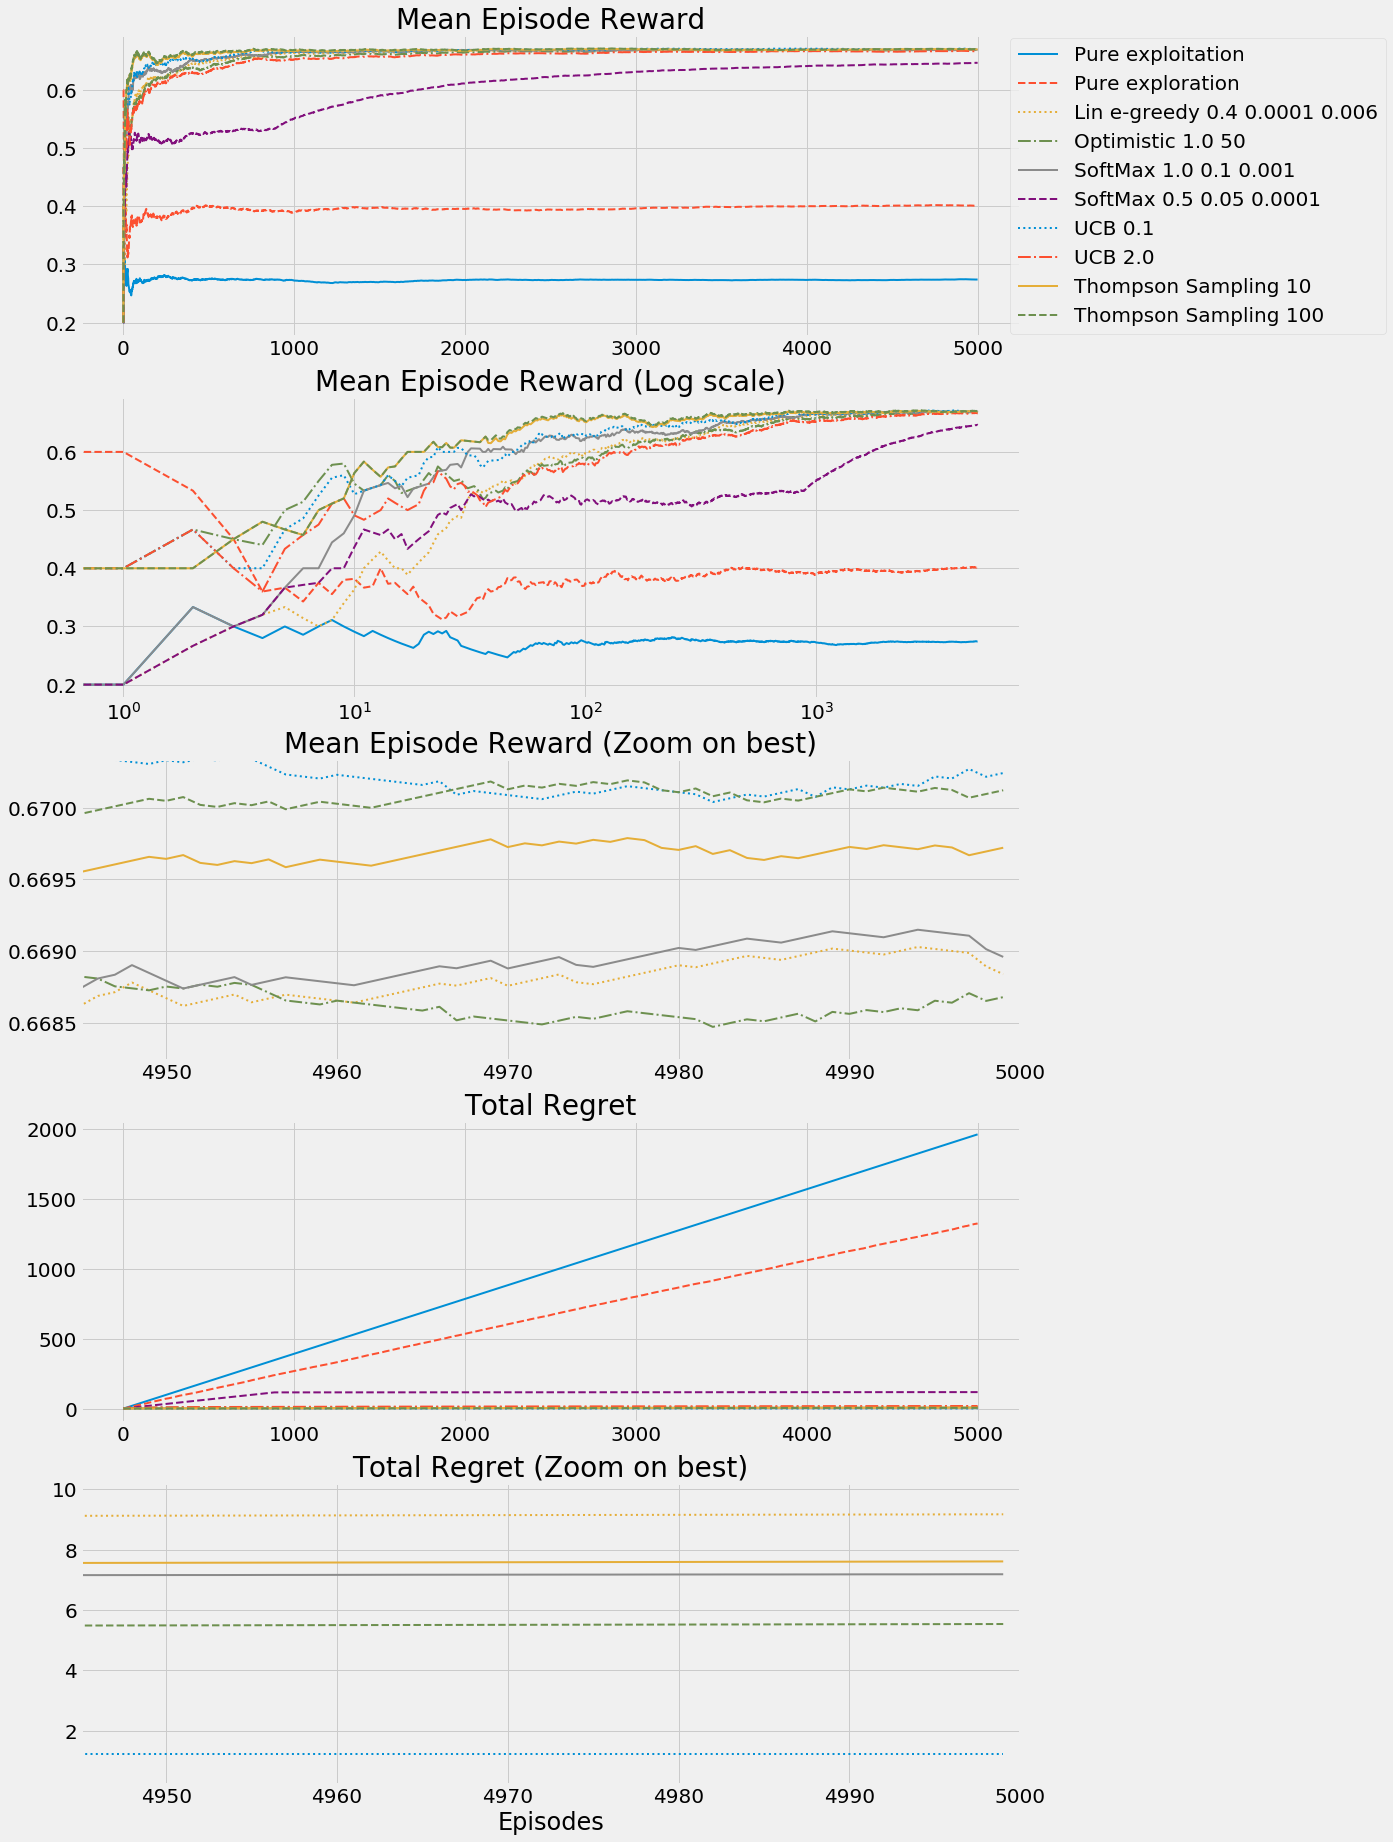

In [17]:
fig, axs = plt.subplots(5, 1, figsize=(15, 30), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b2_results_a.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((mean_episode_mean_rew.shape[0]*0.989,
                 mean_episode_mean_rew.shape[0],
                 max_ret-0.002,
                 max_ret+0.0001))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((mean_cum_regret.shape[0]*0.989,
              mean_cum_regret.shape[0],
              min_reg-1,
              min_reg+9))

    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.5))

plt.show()

# 10-armed Gaussian bandit environments

In [18]:
b10_Vs = []
for seed in [12, 34, 56, 78, 90]:
    env_name = 'BanditTenArmedGaussian-v0'
    np.random.seed(seed) ; random.seed(seed)
    env = gym.make(env_name) ; env.seed(seed) ; env.reset()
    r_dist = np.array(env.env.r_dist)[:,0]
    b10_Q = np.array(env.env.p_dist * r_dist)
    print('10-armed bandit with seed', seed)
    print('Probability of reward:', env.env.p_dist)
    print('Reward:', r_dist)
    print('Q(.):', b10_Q)
    b10_Vs.append(np.max(b10_Q))
    print('V*:', b10_Vs[-1])
    print()
print('Mean V* across all seeds:', np.mean(b10_Vs))

10-armed bandit with seed 12
Probability of reward: [1 1 1 1 1 1 1 1 1 1]
Reward: [ 0.47298583 -0.68142588  0.2424395  -1.70073563  0.75314283 -1.53472134
  0.00512708 -0.12022767 -0.80698188  2.87181939]
Q(.): [ 0.47298583 -0.68142588  0.2424395  -1.70073563  0.75314283 -1.53472134
  0.00512708 -0.12022767 -0.80698188  2.87181939]
V*: 2.8718193949889166

10-armed bandit with seed 34
Probability of reward: [1 1 1 1 1 1 1 1 1 1]
Reward: [ 0.2438351  -0.74731818 -1.56117699 -0.46425312 -0.35206234 -1.28149188
  0.28929924  0.9800285   0.47792422  0.45081813]
Q(.): [ 0.2438351  -0.74731818 -1.56117699 -0.46425312 -0.35206234 -1.28149188
  0.28929924  0.9800285   0.47792422  0.45081813]
V*: 0.980028504824327

10-armed bandit with seed 56
Probability of reward: [1 1 1 1 1 1 1 1 1 1]
Reward: [-1.03764318  0.59365816  1.10268062 -0.51217773 -0.26541986 -1.61700601
 -0.27151449  0.94555425 -0.62699279 -0.26594728]
Q(.): [-1.03764318  0.59365816  1.10268062 -0.51217773 -0.26541986 -1.61700601
 

# Running simple strategies on 10-armed bandit environments

In [19]:
def b10_run_simple_strategies_experiment(env_name='BanditTenArmedGaussian-v0'):
    results = {}
    for seed in tqdm([12, 34, 56, 78, 90], desc='All experiments'):
        experiments = [
            # baseline strategies
            lambda env: pure_exploitation(env),
            lambda env: pure_exploration(env), 

            # # epsilon greedy
            lambda env: epsilon_greedy(env, epsilon=0.01),
            lambda env: epsilon_greedy(env, epsilon=0.02),

            # epsilon greedy linearly decaying
            lambda env: lin_dec_epsilon_greedy(env, 
                                               init_epsilon=1.0, 
                                               min_epsilon=0.0001, 
                                               decay_ratio=0.005),
            lambda env: lin_dec_epsilon_greedy(env, 
                                               init_epsilon=0.4, 
                                               min_epsilon=0.005, 
                                               decay_ratio=0.02),

            # epsilon greedy exponentially decaying
            lambda env: exp_dec_epsilon_greedy(env, 
                                               init_epsilon=1.0, 
                                               min_epsilon=0.0001, 
                                               decay_ratio=0.03),
            lambda env: exp_dec_epsilon_greedy(env, 
                                               init_epsilon=0.5, 
                                               min_epsilon=0.0, 
                                               decay_ratio=0.04),

            # optimistic
            lambda env: optimistic_initialization(env, 
                                                  optimistic_estimate=2.0, 
                                                  initial_count=20),
            lambda env: optimistic_initialization(env, 
                                                  optimistic_estimate=4.0, 
                                                  initial_count=5),            
        ]
        for experiment in tqdm(experiments, 
                               desc='Experiments with seed {}'.format(seed), 
                               leave=False):
            np.random.seed(seed) ; random.seed(seed)
            env = gym.make(env_name) ; env.seed(seed) ; env.reset()    
            name, Re, Qe, Ae = experiment(env)
            Ae = np.expand_dims(Ae, -1)
            r_dist = np.array(env.env.r_dist)[:,0]
            true_Q = np.array(env.env.p_dist * r_dist)
            opt_V = np.max(true_Q)
            episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
            Q_selected = np.take_along_axis(
                np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
            regret = opt_V - Q_selected
            cum_regret = np.cumsum(regret)
            if name not in results.keys(): results[name] = {}
            if 'Re' not in results[name].keys(): results[name]['Re'] = []
            if 'Qe' not in results[name].keys(): results[name]['Qe'] = []
            if 'Ae' not in results[name].keys(): results[name]['Ae'] = []
            if 'cum_regret' not in results[name].keys(): 
                results[name]['cum_regret'] = []
            if 'episode_mean_rew' not in results[name].keys(): 
                results[name]['episode_mean_rew'] = []
            
            results[name]['Re'].append(Re)
            results[name]['Qe'].append(Qe)
            results[name]['Ae'].append(Ae)
            results[name]['cum_regret'].append(cum_regret)
            results[name]['episode_mean_rew'].append(episode_mean_rew)
    return results

b10_results_s = b10_run_simple_strategies_experiment()

# Plotting results of simple strategies on 10-armed bandit environments

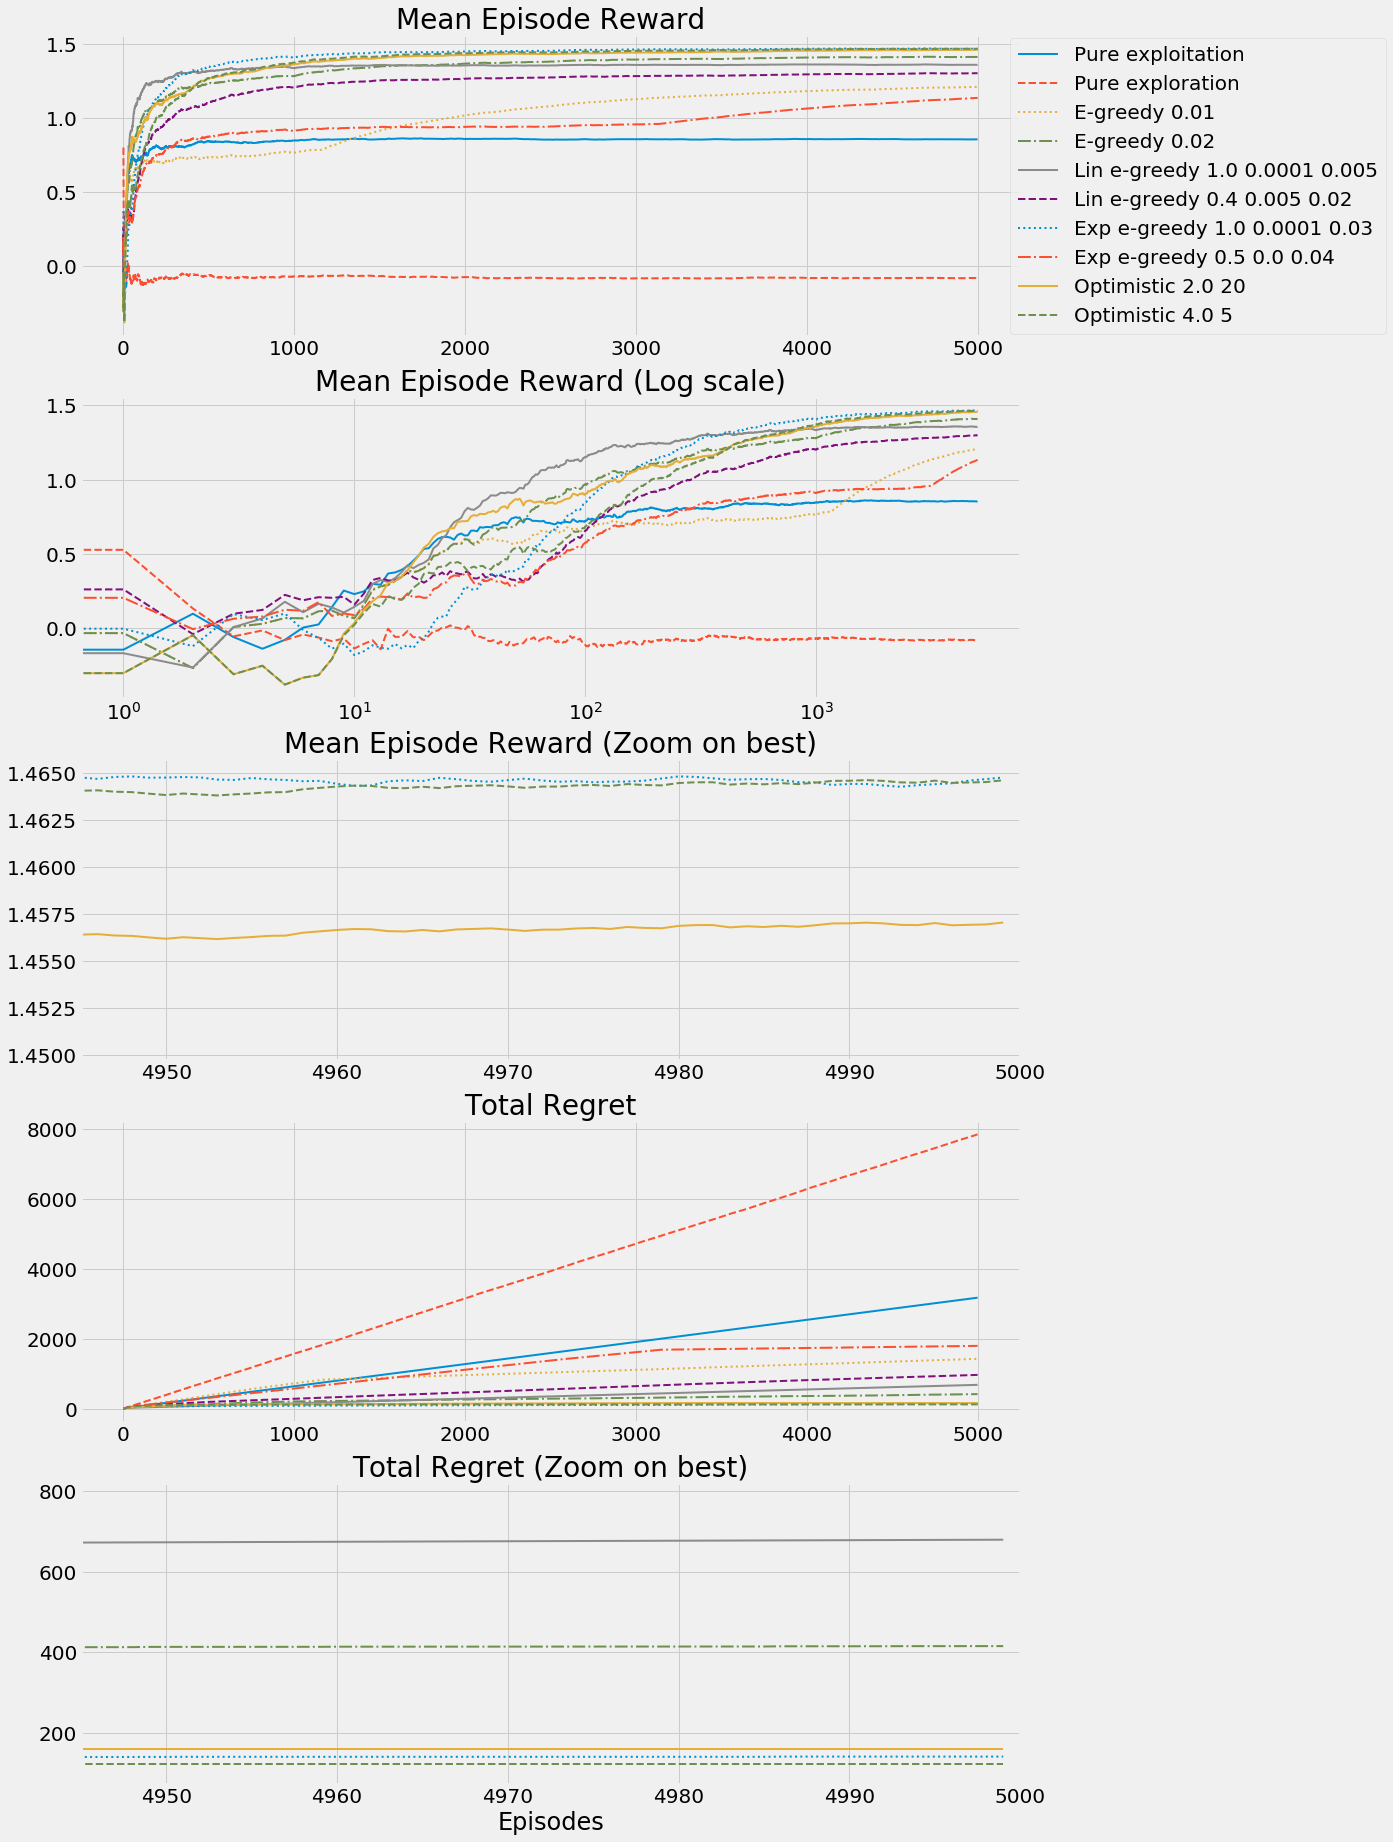

In [20]:
fig, axs = plt.subplots(5, 1, figsize=(15, 30), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b10_results_s.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((mean_episode_mean_rew.shape[0]*0.989,
                 mean_episode_mean_rew.shape[0],
                 max_ret-0.015,
                 max_ret+0.001))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((mean_cum_regret.shape[0]*0.989,
              mean_cum_regret.shape[0],
              min_reg-50,
              min_reg+700))

    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.5))

plt.show()

# Running advanced strategies on 10-armed bandit environments

In [21]:
def b10_run_advanced_strategies_experiment(env_name='BanditTenArmedGaussian-v0'):
    results = {}
    for seed in tqdm([12, 34, 56, 78, 90], desc='All experiments'):
        experiments = [
            # baseline strategies
            lambda env: pure_exploitation(env),
            lambda env: pure_exploration(env),

            # best from simple strategies
            lambda env: exp_dec_epsilon_greedy(env, 
                                               init_epsilon=0.5, 
                                               min_epsilon=0.0, 
                                               decay_ratio=0.04),
            lambda env: optimistic_initialization(env, 
                                                  optimistic_estimate=4.0, 
                                                  initial_count=5),
            
            # softmax
            lambda env: softmax(env, 
                                init_temp=1.0, 
                                min_temp=0.1, 
                                decay_ratio=0.001),
            lambda env: softmax(env, 
                                init_temp=0.5, 
                                min_temp=0.05, 
                                decay_ratio=0.0001),

            # ucb
            lambda env: upper_confidence_bound(env, c=0.1),
            lambda env: upper_confidence_bound(env, c=2.0),

            # thompson sampling
            lambda env: thompson_sampling(env, tau=10),
            lambda env: thompson_sampling(env, tau=100),
        ]
        for experiment in tqdm(experiments, 
                               desc='Experiments with seed {}'.format(seed), 
                               leave=False):
            np.random.seed(seed) ; random.seed(seed)
            env = gym.make(env_name) ; env.seed(seed) ; env.reset()    
            name, Re, Qe, Ae = experiment(env)
            Ae = np.expand_dims(Ae, -1)
            r_dist = np.array(env.env.r_dist)[:,0]
            true_Q = np.array(env.env.p_dist * r_dist)
            opt_V = np.max(true_Q)
            episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
            Q_selected = np.take_along_axis(
                np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
            regret = opt_V - Q_selected
            cum_regret = np.cumsum(regret)
            if name not in results.keys(): results[name] = {}
            if 'Re' not in results[name].keys(): results[name]['Re'] = []
            if 'Qe' not in results[name].keys(): results[name]['Qe'] = []
            if 'Ae' not in results[name].keys(): results[name]['Ae'] = []
            if 'cum_regret' not in results[name].keys(): 
                results[name]['cum_regret'] = []
            if 'episode_mean_rew' not in results[name].keys():
                results[name]['episode_mean_rew'] = []
            
            results[name]['Re'].append(Re)
            results[name]['Qe'].append(Qe)
            results[name]['Ae'].append(Ae)
            results[name]['cum_regret'].append(cum_regret)
            results[name]['episode_mean_rew'].append(episode_mean_rew)
    return results

b10_results_a = b10_run_advanced_strategies_experiment()

# Plotting results of advanced strategies on 10-armed bandit environments

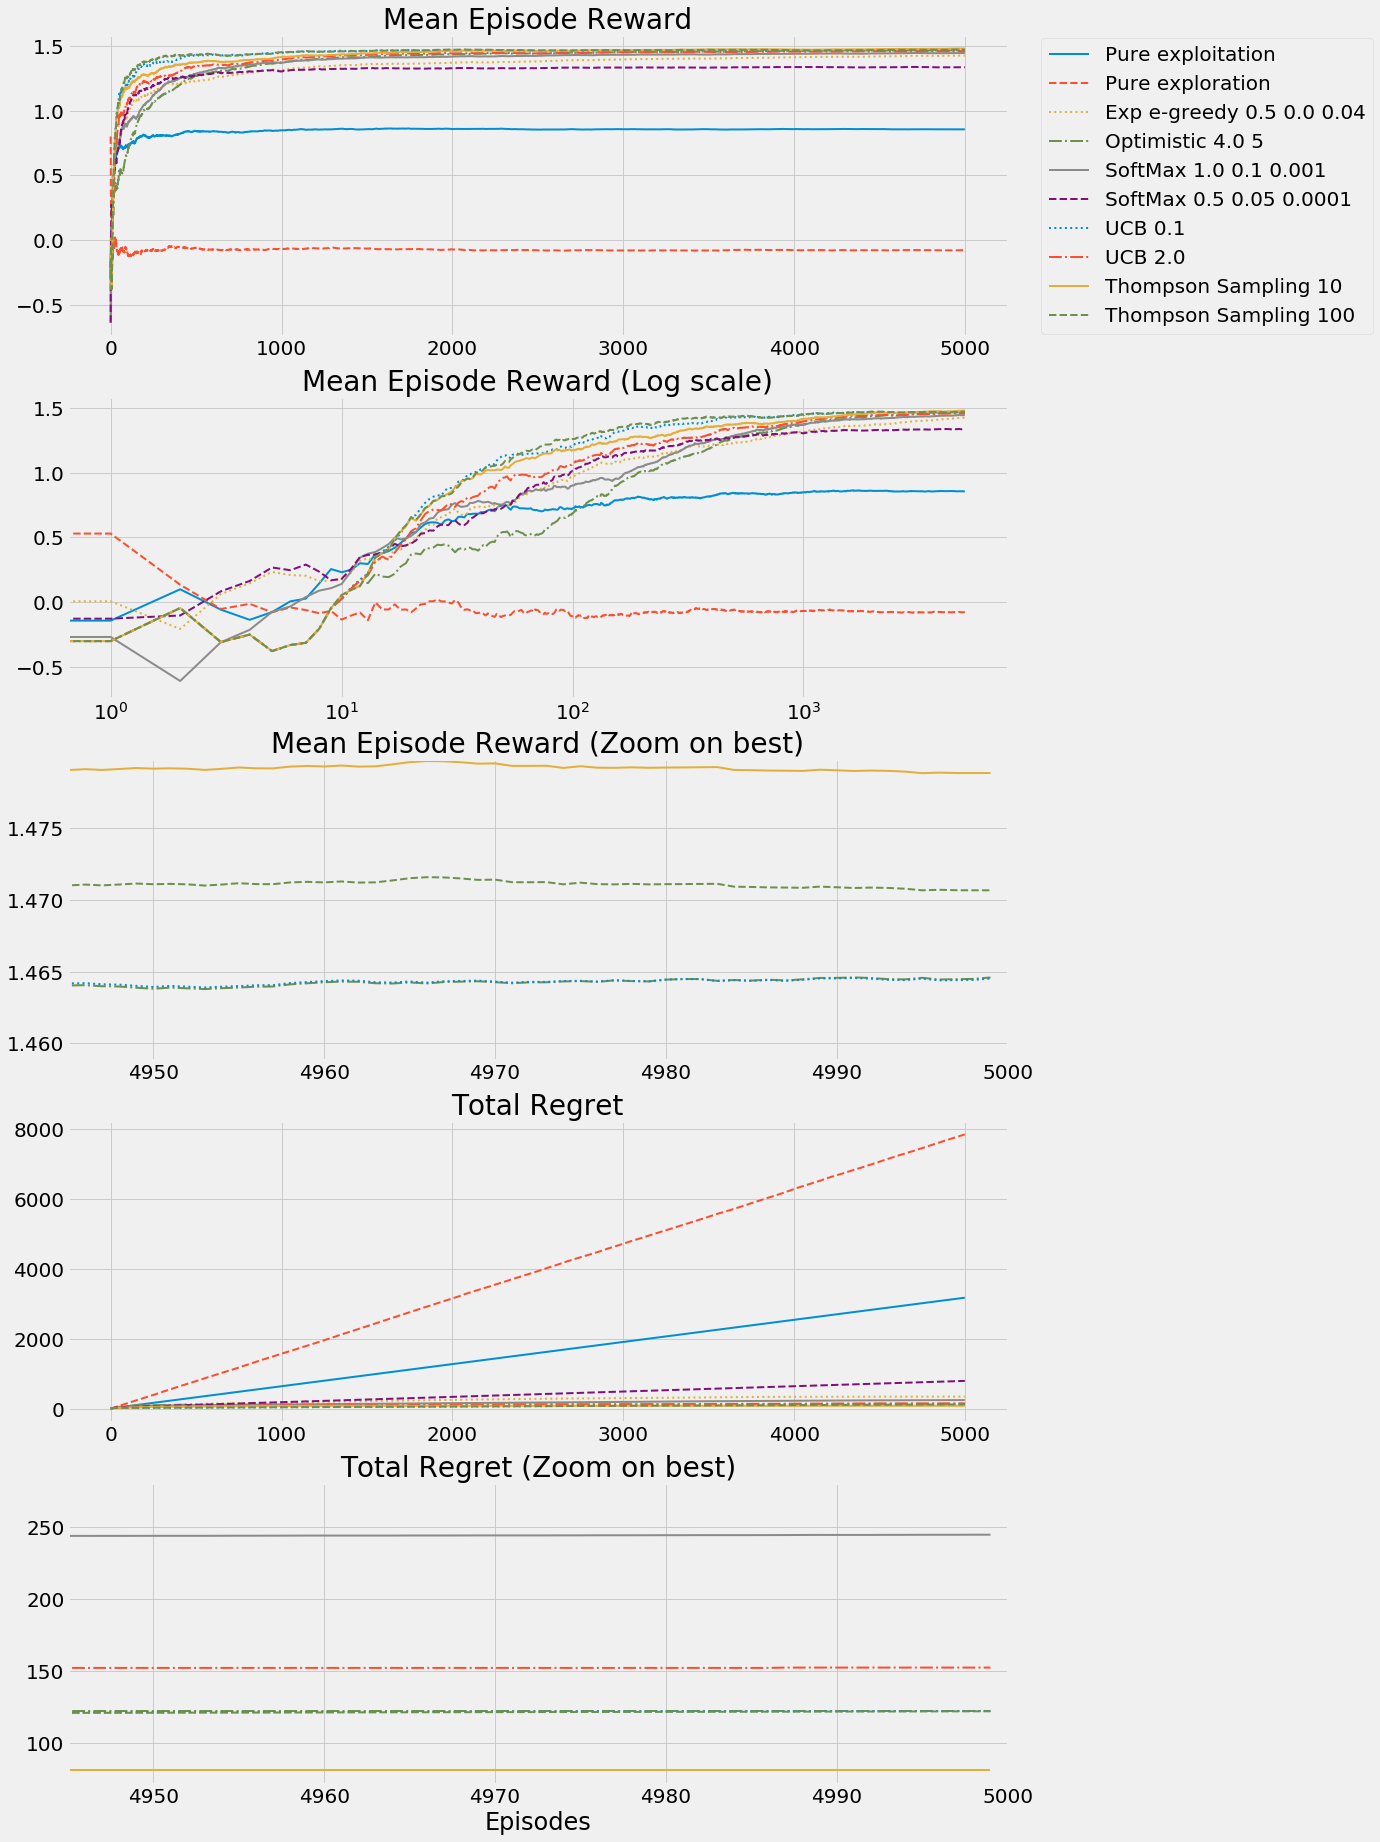

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(15, 30), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b10_results_a.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((mean_episode_mean_rew.shape[0]*0.989,
                 mean_episode_mean_rew.shape[0],
                 max_ret-0.02,
                 max_ret+0.001))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((mean_cum_regret.shape[0]*0.989,
              mean_cum_regret.shape[0],
              min_reg-10,
              min_reg+200))

    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.5))

plt.show()